# 3D Multi-class Segmentation with UNETR  (Muscle, Fat (subcut and internal), psoas,Cavity,BGD)

## Setup environment

In [1]:
!pip install -q "monai-weekly[nibabel, tqdm, einops]"
!python -c "import matplotlib" || pip install -q matplotlib
%matplotlib inline

In [2]:
import os
import shutil
import tempfile

import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

from monai.losses import DiceCELoss
from monai.inferers import sliding_window_inference
from monai.transforms import (
    AsDiscrete,
    EnsureChannelFirstd,
    AddChanneld,
    Compose,
    CropForegroundd,
    LoadImaged,
    Orientationd,
    RandFlipd,
    RandCropByPosNegLabeld,
    RandShiftIntensityd,
    SaveImaged,
    ScaleIntensityRanged,
    Spacingd,
    RandRotate90d,
    ToTensord,
)

from monai.config import print_config
from monai.metrics import DiceMetric
from monai.networks.nets import SwinUNETR

from monai.data import (
    DataLoader,
    CacheDataset,
    load_decathlon_datalist,
    decollate_batch,
)


import torch

print_config()

MONAI version: 0.10.dev2231
Numpy version: 1.23.1
Pytorch version: 1.12.0+cu102
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 8236821c099e5997f7ad0410c5374e4472f4ed14
MONAI __file__: /home/adminbthomas/miniconda3/envs/PT02/lib/python3.9/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: 0.4.9
Nibabel version: 4.0.1
scikit-image version: 0.19.3
Pillow version: 9.2.0
Tensorboard version: 2.9.1
gdown version: 4.5.1
TorchVision version: 0.13.0+cu102
tqdm version: 4.64.0
lmdb version: 1.3.0
psutil version: 5.9.1
pandas version: 1.4.3
einops version: 0.4.1
transformers version: 4.20.1
mlflow version: 1.27.0
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



## Setup data directory

In [3]:
# directory = os.environ.get("MONAI_DATA_DIRECTORY")
root_dir = "/home/adminbthomas/Downloads/ensemble/unetr"# root_dir = tempfile.mkdtemp() if directory is None else directory
print(root_dir)

/home/adminbthomas/Downloads/ensemble/unetr


## Setup transforms for training and validation

In [4]:
import datetime
import time

train_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"], ensure_channel_first=True),
#         AddChanneld(keys=["image", "label"]),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(
            keys=["image", "label"],
            pixdim=(1.5, 1.5, 1.0),
            mode=("bilinear", "nearest"),
        ),
        ScaleIntensityRanged(
            keys=["image"],
            a_min=0,
            a_max=250,
            b_min=0.0,
            b_max=1.0,
            clip=False,   # change-intermedouts 
        ),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        RandCropByPosNegLabeld(
            keys=["image", "label"],
            label_key="label",
            spatial_size=(96, 96, 96),
            pos=1,
            neg=1,
            num_samples=4,
            image_key="image",
            image_threshold=0,
        ),
        RandFlipd(
            keys=["image", "label"],
            spatial_axis=[0],
            prob=0.10,
        ),
        RandFlipd(
            keys=["image", "label"],
            spatial_axis=[1],
            prob=0.10,
        ),
        RandFlipd(
            keys=["image", "label"],
            spatial_axis=[2],
            prob=0.10,
        ),
        RandRotate90d(
            keys=["image", "label"],
            prob=0.10,
            max_k=3,
        ),
        RandShiftIntensityd(
            keys=["image"],
            offsets=0.10,
            prob=0.50,
        ),
        ToTensord(keys=["image", "label"]),
#         SaveImaged(keys="image", meta_keys="image_meta_dict", output_dir="./outMR02_Jul23_Interinputs", output_postfix=datetime.datetime.now().strftime('%f'), resample=False, separate_folder=False),
#         SaveImaged(keys="label", meta_keys="label_meta_dict", output_dir="./outMR02_Jul23_Interinputs", output_postfix=datetime.datetime.now().strftime('%f'), resample=False, separate_folder=False),
    ]
)
val_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"], ensure_channel_first=True),
#         AddChanneld(keys=["image", "label"]),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(
            keys=["image", "label"],
            pixdim=(1.5, 1.5, 1.0),
            mode=("bilinear", "nearest"),
        ),
        ScaleIntensityRanged(
            keys=["image"], a_min=0, a_max=250, b_min=0.0, b_max=1.0, clip=False
        ),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        ToTensord(keys=["image", "label"]),
    ]
)

### DATA

In [5]:
data_dir = os.path.join(root_dir,"data/")

In [6]:
# data_dir = os.path.join(root_dir,"013123_MR/")
split_JSON = "dataset_MR09fold1.json"
datasets = data_dir + split_JSON
datalist = load_decathlon_datalist(datasets, True, "training")
val_files = load_decathlon_datalist(datasets, True, "validation")
train_ds = CacheDataset(
    data=datalist,
    transform=train_transforms,
    cache_num=24,
    cache_rate=1.0,
    num_workers=8,
)
train_loader = DataLoader(
    train_ds, batch_size=1, shuffle=True, num_workers=8, pin_memory=True
)
val_ds = CacheDataset(
    data=val_files, transform=val_transforms, cache_num=6, cache_rate=1.0, num_workers=4
)
val_loader = DataLoader(
    val_ds, batch_size=1, shuffle=False, num_workers=4, pin_memory=True
)

Loading dataset:   0%|                                                                                                                                                       | 0/12 [00:00<?, ?it/s]Modifying image pixdim from [1.4648438 1.4648438 4.        0.       ] to [  1.46484375   1.46484375   4.         268.45717811]
Modifying image pixdim from [1.4648438 1.4648438 8.        0.       ] to [  1.46484375   1.46484375   8.         281.03604124]
Loading dataset: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.15it/s]


## Check data shape and visualize

image shape: torch.Size([1, 250, 176, 193]), label shape: torch.Size([1, 250, 176, 193])


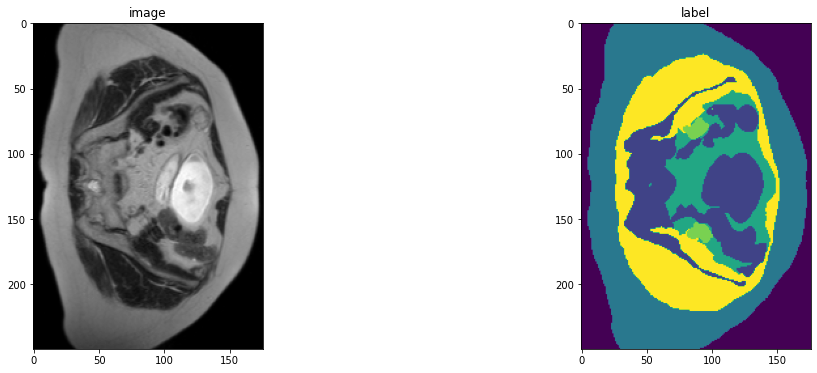

In [7]:
slice_map = {
    "A052_v1_T2W.nii.gz": 10,
    "A052_v1_T2W.nii.gz": 8,
    "A052_v1_T2W.nii.gz": 6
}
case_num = 1
img_name = os.path.split(val_ds[case_num]["image_meta_dict"]["filename_or_obj"])[1]
img = val_ds[case_num]["image"]
label = val_ds[case_num]["label"]
img_shape = img.shape
label_shape = label.shape
print(f"image shape: {img_shape}, label shape: {label_shape}")
plt.figure("image", (18, 6))
plt.subplot(1, 2, 1)
plt.title("image")
plt.imshow(img[0, :, :, slice_map[img_name]].detach().cpu(), cmap="gray")
plt.subplot(1, 2, 2)
plt.title("label")
plt.imshow(label[0, :, :, slice_map[img_name]].detach().cpu())
plt.show()

### Create Model, Loss, Optimizer


In [8]:
#### os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
device = torch.device("cuda:0")

model = SwinUNETR(
    img_size=(96, 96, 96),
    in_channels=1,
    out_channels=6,
    feature_size=12,
    use_checkpoint=True,
).to(device)

loss_function = DiceCELoss(to_onehot_y=True, softmax=True)
torch.backends.cudnn.benchmark = True
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)
scaler = torch.cuda.amp.GradScaler()

### Execute a typical PyTorch training process

In [9]:
def validation(epoch_iterator_val):
    model.eval()
    dice_vals = list()
    with torch.no_grad():
        for step, batch in enumerate(epoch_iterator_val):
            val_inputs, val_labels = (batch["image"].to(device), batch["label"].to(device))
            val_outputs = sliding_window_inference(val_inputs, (96, 96, 96), 4, model)
            val_labels_list = decollate_batch(val_labels)
            val_labels_convert = [
                post_label(val_label_tensor) for val_label_tensor in val_labels_list
            ]
            val_outputs_list = decollate_batch(val_outputs)
            val_output_convert = [
                post_pred(val_pred_tensor) for val_pred_tensor in val_outputs_list
            ]
            dice_metric(y_pred=val_output_convert, y=val_labels_convert)
            dice = dice_metric.aggregate().item()
            dice_vals.append(dice)
            epoch_iterator_val.set_description(
                "Validate (%d / %d Steps) (dice=%2.5f)" % (global_step, 10.0, dice)
            )
        dice_metric.reset()
    mean_dice_val = np.mean(dice_vals)
    return mean_dice_val


def train(global_step, train_loader, dice_val_best, global_step_best):
    model.train()
    epoch_loss = 0
    step = 0
    epoch_iterator = tqdm(
        train_loader, desc="Training (X / X Steps) (loss=X.X)", dynamic_ncols=True
    )
    for step, batch in enumerate(epoch_iterator):
        step += 1
        x, y = (batch["image"].to(device), batch["label"].to(device))
#         print(x.shape)
#         print(y.shape)
#         plt.figure("image", (18, 6))
#         plt.subplot(1, 2, 1)
#         plt.title("image")
#         plt.imshow(x[3,0,:,:,4].detach().cpu(), cmap="gray")
#         plt.subplot(1, 2, 2)
#         plt.title("label")
#         plt.imshow(y[3,0,:,:,4].detach().cpu())
#         plt.show()
        logit_map = model(x)
        loss = loss_function(logit_map, y)
        loss.backward()
        epoch_loss += loss.item()
        optimizer.step()
        optimizer.zero_grad()
        epoch_iterator.set_description(
            "Training (%d / %d Steps) (loss=%2.5f)" % (global_step, max_iterations, loss)
        )
        if (
            global_step % eval_num == 0 and global_step != 0
        ) or global_step == max_iterations:
            epoch_iterator_val = tqdm(
                val_loader, desc="Validate (X / X Steps) (dice=X.X)", dynamic_ncols=True
            )
            dice_val = validation(epoch_iterator_val)
            epoch_loss /= step
            epoch_loss_values.append(epoch_loss)
            metric_values.append(dice_val)
            if dice_val > dice_val_best:
                dice_val_best = dice_val
                global_step_best = global_step
                torch.save(
                    model.state_dict(), os.path.join(data_dir, "TestMR10_swinUNetR_fold1.pth")
                )
                print(
                    "Model Was Saved ! Current Best Avg. Dice: {} Current Avg. Dice: {}".format(
                        dice_val_best, dice_val
                    )
                )
            else:
                print(
                    "Model Was Not Saved ! Current Best Avg. Dice: {} Current Avg. Dice: {}".format(
                        dice_val_best, dice_val
                    )
                )
        global_step += 1
        
    return global_step, dice_val_best, global_step_best


max_iterations = 70000
eval_num = 250
post_label = AsDiscrete(to_onehot=6)
post_pred = AsDiscrete(argmax=True, to_onehot=6)
dice_metric = DiceMetric(include_background=True, reduction="mean", get_not_nans=False)
global_step = 0
dice_val_best = 0.0
global_step_best = 0
epoch_loss_values = []
metric_values = []
while global_step < max_iterations:
    global_step, dice_val_best, global_step_best = train(
        global_step, train_loader, dice_val_best, global_step_best
    )
#     print('I am waiting....')
#     time.sleep(1)
model.load_state_dict(torch.load(os.path.join(data_dir, "TestMR10_swinUNetR_fold1.pth")))

Validate (X / X Steps) (dice=X.X):   0%|                                                                                                                                      | 0/3 [00:00<?, ?it/s]None of the inputs have requires_grad=True. Gradients will be None

Training (250 / 70000 Steps) (loss=1.74461):  92%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 11/12 [00:16<00:02,  2.78s/it]

Model Was Saved ! Current Best Avg. Dice: 0.5709732373555502 Current Avg. Dice: 0.5709732373555502


Training (500 / 70000 Steps) (loss=1.64692):  75%|██████████████████████████████████████████████████████████████████████████████████████▎                            | 9/12 [00:14<00:08,  2.79s/it]

Model Was Saved ! Current Best Avg. Dice: 0.6255214413007101 Current Avg. Dice: 0.6255214413007101


Training (750 / 70000 Steps) (loss=1.14815):  58%|███████████████████████████████████████████████████████████████████                                                | 7/12 [00:12<00:14,  2.90s/it]

Model Was Saved ! Current Best Avg. Dice: 0.6394866704940796 Current Avg. Dice: 0.6394866704940796


Training (1000 / 70000 Steps) (loss=1.38985):  42%|███████████████████████████████████████████████▌                                                                  | 5/12 [00:11<00:22,  3.18s/it]

Model Was Saved ! Current Best Avg. Dice: 0.6563464800516764 Current Avg. Dice: 0.6563464800516764


Training (1250 / 70000 Steps) (loss=0.96860):  25%|████████████████████████████▌                                                                                     | 3/12 [00:09<00:34,  3.85s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.6563464800516764 Current Avg. Dice: 0.6552179455757141


Training (1750 / 70000 Steps) (loss=0.78896):  92%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 11/12 [00:16<00:02,  2.74s/it]

Model Was Saved ! Current Best Avg. Dice: 0.6606080929438273 Current Avg. Dice: 0.6606080929438273


Training (2000 / 70000 Steps) (loss=1.20922):  75%|█████████████████████████████████████████████████████████████████████████████████████▌                            | 9/12 [00:14<00:08,  2.77s/it]

Model Was Saved ! Current Best Avg. Dice: 0.6668727000554403 Current Avg. Dice: 0.6668727000554403


Training (2250 / 70000 Steps) (loss=0.74269):  58%|██████████████████████████████████████████████████████████████████▌                                               | 7/12 [00:12<00:14,  2.89s/it]

Model Was Saved ! Current Best Avg. Dice: 0.6744533181190491 Current Avg. Dice: 0.6744533181190491


Training (2500 / 70000 Steps) (loss=1.27455):  42%|███████████████████████████████████████████████▌                                                                  | 5/12 [00:11<00:21,  3.14s/it]

Model Was Saved ! Current Best Avg. Dice: 0.6772989432017008 Current Avg. Dice: 0.6772989432017008


Training (2750 / 70000 Steps) (loss=0.70481):  25%|████████████████████████████▌                                                                                     | 3/12 [00:09<00:34,  3.82s/it]

Model Was Saved ! Current Best Avg. Dice: 0.6818291544914246 Current Avg. Dice: 0.6818291544914246


Training (2813 / 70000 Steps) (loss=0.75368):  50%|█████████████████████████████████████████████████████████                                                         | 6/12 [00:05<00:05,  1.18it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Training (4250 / 70000 Steps) (loss=0.64960):  25%|████████████████████████████▌                                                                                     | 3/12 [00:09<00:34,  3.83s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.6891133983929952 Current Avg. Dice: 0.6849718888600668


Training (4500 / 70000 Steps) (loss=0.56993):   8%|█████████▌                                                                                                        | 1/12 [00:07<01:26,  7.88s/it]

Model Was Saved ! Current Best Avg. Dice: 0.7027369936307272 Current Avg. Dice: 0.7027369936307272


Training (4750 / 70000 Steps) (loss=0.58104):  92%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 11/12 [00:15<00:02,  2.74s/it]

Model Was Saved ! Current Best Avg. Dice: 0.7198190093040466 Current Avg. Dice: 0.7198190093040466


Training (5000 / 70000 Steps) (loss=0.81275):  75%|█████████████████████████████████████████████████████████████████████████████████████▌                            | 9/12 [00:14<00:08,  2.79s/it]

Model Was Saved ! Current Best Avg. Dice: 0.7654093305269877 Current Avg. Dice: 0.7654093305269877


Training (5250 / 70000 Steps) (loss=0.41607):  58%|██████████████████████████████████████████████████████████████████▌                                               | 7/12 [00:12<00:14,  2.90s/it]

Model Was Saved ! Current Best Avg. Dice: 0.7861742178599039 Current Avg. Dice: 0.7861742178599039


Training (5500 / 70000 Steps) (loss=0.50844):  42%|███████████████████████████████████████████████▌                                                                  | 5/12 [00:11<00:22,  3.15s/it]

Model Was Saved ! Current Best Avg. Dice: 0.8075621326764425 Current Avg. Dice: 0.8075621326764425


Training (5750 / 70000 Steps) (loss=0.63624):  25%|████████████████████████████▌                                                                                     | 3/12 [00:09<00:34,  3.89s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8075621326764425 Current Avg. Dice: 0.8027837872505188


Training (6000 / 70000 Steps) (loss=0.38281):   8%|█████████▌                                                                                                        | 1/12 [00:07<01:26,  7.87s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8075621326764425 Current Avg. Dice: 0.8072752952575684


Training (6250 / 70000 Steps) (loss=0.52210):  92%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 11/12 [00:15<00:02,  2.75s/it]

Model Was Saved ! Current Best Avg. Dice: 0.8142365018526713 Current Avg. Dice: 0.8142365018526713


Training (6500 / 70000 Steps) (loss=0.38616):  75%|█████████████████████████████████████████████████████████████████████████████████████▌                            | 9/12 [00:14<00:08,  2.75s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8142365018526713 Current Avg. Dice: 0.8130573431650797


Training (6750 / 70000 Steps) (loss=0.39612):  58%|██████████████████████████████████████████████████████████████████▌                                               | 7/12 [00:12<00:14,  2.88s/it]

Model Was Saved ! Current Best Avg. Dice: 0.8170576691627502 Current Avg. Dice: 0.8170576691627502


Training (7000 / 70000 Steps) (loss=0.43261):  42%|███████████████████████████████████████████████▌                                                                  | 5/12 [00:11<00:22,  3.17s/it]

Model Was Saved ! Current Best Avg. Dice: 0.8194209933280945 Current Avg. Dice: 0.8194209933280945


Training (7250 / 70000 Steps) (loss=0.43830):  25%|████████████████████████████▌                                                                                     | 3/12 [00:09<00:34,  3.81s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8194209933280945 Current Avg. Dice: 0.8193472226460775


Training (7500 / 70000 Steps) (loss=0.49041):   8%|█████████▌                                                                                                        | 1/12 [00:07<01:27,  7.92s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8194209933280945 Current Avg. Dice: 0.8154821594556173


Training (7750 / 70000 Steps) (loss=0.35096):  92%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 11/12 [00:15<00:02,  2.70s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8194209933280945 Current Avg. Dice: 0.8189404010772705


Training (8000 / 70000 Steps) (loss=0.41650):  75%|█████████████████████████████████████████████████████████████████████████████████████▌                            | 9/12 [00:14<00:08,  2.75s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8194209933280945 Current Avg. Dice: 0.8193373084068298


Training (8250 / 70000 Steps) (loss=0.36799):  58%|██████████████████████████████████████████████████████████████████▌                                               | 7/12 [00:12<00:14,  2.87s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8194209933280945 Current Avg. Dice: 0.8155612548192342


Training (8500 / 70000 Steps) (loss=0.35374):  42%|███████████████████████████████████████████████▌                                                                  | 5/12 [00:11<00:22,  3.18s/it]

Model Was Saved ! Current Best Avg. Dice: 0.8213632901509603 Current Avg. Dice: 0.8213632901509603


Training (8750 / 70000 Steps) (loss=0.33614):  25%|████████████████████████████▌                                                                                     | 3/12 [00:09<00:34,  3.85s/it]

Model Was Saved ! Current Best Avg. Dice: 0.8221299052238464 Current Avg. Dice: 0.8221299052238464


Training (9000 / 70000 Steps) (loss=0.31654):   8%|█████████▌                                                                                                        | 1/12 [00:07<01:27,  8.00s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8221299052238464 Current Avg. Dice: 0.8213153878847758


Training (9250 / 70000 Steps) (loss=0.42674):  92%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 11/12 [00:16<00:02,  2.75s/it]

Model Was Saved ! Current Best Avg. Dice: 0.8237064679463705 Current Avg. Dice: 0.8237064679463705


Training (9500 / 70000 Steps) (loss=0.50957):  75%|█████████████████████████████████████████████████████████████████████████████████████▌                            | 9/12 [00:14<00:08,  2.77s/it]

Model Was Saved ! Current Best Avg. Dice: 0.8280482292175293 Current Avg. Dice: 0.8280482292175293


Training (9750 / 70000 Steps) (loss=0.27525):  58%|██████████████████████████████████████████████████████████████████▌                                               | 7/12 [00:13<00:14,  2.90s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8280482292175293 Current Avg. Dice: 0.8255414764086405


Training (10000 / 70000 Steps) (loss=0.34056):  42%|███████████████████████████████████████████████                                                                  | 5/12 [00:11<00:22,  3.16s/it]

Model Was Saved ! Current Best Avg. Dice: 0.8288807471593221 Current Avg. Dice: 0.8288807471593221


Training (10250 / 70000 Steps) (loss=0.37147):  25%|████████████████████████████▎                                                                                    | 3/12 [00:09<00:34,  3.83s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8288807471593221 Current Avg. Dice: 0.8253881335258484


Training (10500 / 70000 Steps) (loss=0.34295):   8%|█████████▍                                                                                                       | 1/12 [00:07<01:26,  7.91s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8288807471593221 Current Avg. Dice: 0.8161362210909525


Training (10750 / 70000 Steps) (loss=0.39941):  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 11/12 [00:15<00:02,  2.72s/it]

Model Was Saved ! Current Best Avg. Dice: 0.8302592635154724 Current Avg. Dice: 0.8302592635154724


Training (11000 / 70000 Steps) (loss=0.36354):  75%|████████████████████████████████████████████████████████████████████████████████████▊                            | 9/12 [00:14<00:08,  2.80s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8302592635154724 Current Avg. Dice: 0.82614799340566


Training (11250 / 70000 Steps) (loss=0.38541):  58%|█████████████████████████████████████████████████████████████████▉                                               | 7/12 [00:12<00:14,  2.85s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8302592635154724 Current Avg. Dice: 0.8267139395078024


Training (11500 / 70000 Steps) (loss=0.49189):  42%|███████████████████████████████████████████████                                                                  | 5/12 [00:10<00:21,  3.11s/it]

Model Was Saved ! Current Best Avg. Dice: 0.8309235175450643 Current Avg. Dice: 0.8309235175450643


Training (11750 / 70000 Steps) (loss=0.35383):  25%|████████████████████████████▎                                                                                    | 3/12 [00:09<00:34,  3.82s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8309235175450643 Current Avg. Dice: 0.8280185659726461


Training (12000 / 70000 Steps) (loss=0.30492):   8%|█████████▍                                                                                                       | 1/12 [00:08<01:30,  8.19s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8309235175450643 Current Avg. Dice: 0.8300195137659708


Training (12250 / 70000 Steps) (loss=0.33853):  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 11/12 [00:16<00:02,  2.75s/it]

Model Was Saved ! Current Best Avg. Dice: 0.8317332665125529 Current Avg. Dice: 0.8317332665125529


Training (12500 / 70000 Steps) (loss=0.32550):  75%|████████████████████████████████████████████████████████████████████████████████████▊                            | 9/12 [00:14<00:08,  2.78s/it]

Model Was Saved ! Current Best Avg. Dice: 0.8318296472231547 Current Avg. Dice: 0.8318296472231547


Training (12750 / 70000 Steps) (loss=0.31624):  58%|█████████████████████████████████████████████████████████████████▉                                               | 7/12 [00:12<00:14,  2.88s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8318296472231547 Current Avg. Dice: 0.8268241683642069


Training (13000 / 70000 Steps) (loss=0.34105):  42%|███████████████████████████████████████████████                                                                  | 5/12 [00:11<00:21,  3.11s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8318296472231547 Current Avg. Dice: 0.8237242499987284


Training (13250 / 70000 Steps) (loss=0.21799):  25%|████████████████████████████▎                                                                                    | 3/12 [00:09<00:34,  3.87s/it]

Model Was Saved ! Current Best Avg. Dice: 0.8349607189496359 Current Avg. Dice: 0.8349607189496359


Training (13500 / 70000 Steps) (loss=0.49372):   8%|█████████▍                                                                                                       | 1/12 [00:07<01:27,  7.94s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8349607189496359 Current Avg. Dice: 0.8309537172317505


Training (13750 / 70000 Steps) (loss=0.20446):  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 11/12 [00:15<00:02,  2.71s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8349607189496359 Current Avg. Dice: 0.8322648008664449


Training (14000 / 70000 Steps) (loss=0.31602):  75%|████████████████████████████████████████████████████████████████████████████████████▊                            | 9/12 [00:14<00:08,  2.78s/it]

Model Was Saved ! Current Best Avg. Dice: 0.8357916275660197 Current Avg. Dice: 0.8357916275660197


Training (14250 / 70000 Steps) (loss=0.36121):  58%|█████████████████████████████████████████████████████████████████▉                                               | 7/12 [00:12<00:14,  2.87s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8357916275660197 Current Avg. Dice: 0.8349843819936117


Training (14500 / 70000 Steps) (loss=0.30051):  42%|███████████████████████████████████████████████                                                                  | 5/12 [00:11<00:21,  3.13s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8357916275660197 Current Avg. Dice: 0.831901748975118


Training (14750 / 70000 Steps) (loss=0.41336):  25%|████████████████████████████▎                                                                                    | 3/12 [00:09<00:34,  3.85s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8357916275660197 Current Avg. Dice: 0.8332144021987915


Training (15000 / 70000 Steps) (loss=0.34936):   8%|█████████▍                                                                                                       | 1/12 [00:07<01:27,  8.00s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8357916275660197 Current Avg. Dice: 0.8327567378679911


Training (15250 / 70000 Steps) (loss=0.49619):  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 11/12 [00:15<00:02,  2.71s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8357916275660197 Current Avg. Dice: 0.8353465994199117


Training (15500 / 70000 Steps) (loss=0.26601):  75%|████████████████████████████████████████████████████████████████████████████████████▊                            | 9/12 [00:14<00:08,  2.75s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8357916275660197 Current Avg. Dice: 0.8285073836644491


Training (15750 / 70000 Steps) (loss=0.34897):  58%|█████████████████████████████████████████████████████████████████▉                                               | 7/12 [00:12<00:14,  2.85s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8357916275660197 Current Avg. Dice: 0.8297128876050314


Training (16000 / 70000 Steps) (loss=0.28059):  42%|███████████████████████████████████████████████                                                                  | 5/12 [00:11<00:22,  3.15s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8357916275660197 Current Avg. Dice: 0.834260622660319


Training (16500 / 70000 Steps) (loss=0.35578):   8%|█████████▍                                                                                                       | 1/12 [00:07<01:26,  7.88s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8357916275660197 Current Avg. Dice: 0.8340356151262919


Training (16750 / 70000 Steps) (loss=0.30689):  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 11/12 [00:16<00:02,  2.71s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8357916275660197 Current Avg. Dice: 0.8278259038925171


Training (17000 / 70000 Steps) (loss=0.53157):  75%|████████████████████████████████████████████████████████████████████████████████████▊                            | 9/12 [00:14<00:08,  2.79s/it]

Model Was Saved ! Current Best Avg. Dice: 0.8409990866978964 Current Avg. Dice: 0.8409990866978964


Training (17250 / 70000 Steps) (loss=0.34670):  58%|█████████████████████████████████████████████████████████████████▉                                               | 7/12 [00:12<00:14,  2.86s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8409990866978964 Current Avg. Dice: 0.8386232852935791


Training (17500 / 70000 Steps) (loss=0.35444):  42%|███████████████████████████████████████████████                                                                  | 5/12 [00:11<00:21,  3.13s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8409990866978964 Current Avg. Dice: 0.8407873113950094


Training (X / X Steps) (loss=X.X):   0%|                                                                                                                                     | 0/12 [00:00<?, ?it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Training (24500 / 70000 Steps) (loss=0.36024):  75%|████████████████████████████████████████████████████████████████████████████████████▊                            | 9/12 [00:14<00:08,  2.76s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8419399658838908 Current Avg. Dice: 0.8363543550173441


Training (24750 / 70000 Steps) (loss=0.35288):  58%|█████████████████████████████████████████████████████████████████▉                                               | 7/12 [00:12<00:14,  2.89s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8419399658838908 Current Avg. Dice: 0.8373602430025736


Training (25000 / 70000 Steps) (loss=0.19657):  42%|███████████████████████████████████████████████                                                                  | 5/12 [00:11<00:21,  3.12s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8419399658838908 Current Avg. Dice: 0.8340782324473063


Training (25250 / 70000 Steps) (loss=0.25465):  25%|████████████████████████████▎                                                                                    | 3/12 [00:09<00:34,  3.87s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8419399658838908 Current Avg. Dice: 0.8352568745613098


Training (25500 / 70000 Steps) (loss=0.22356):   8%|█████████▍                                                                                                       | 1/12 [00:07<01:26,  7.90s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8419399658838908 Current Avg. Dice: 0.8365809321403503


Training (25570 / 70000 Steps) (loss=0.31196):  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 11/12 [00:09<00:00,  1.23it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Training (30500 / 70000 Steps) (loss=0.30069):  75%|████████████████████████████████████████████████████████████████████████████████████▊                            | 9/12 [00:14<00:08,  2.83s/it]

Model Was Saved ! Current Best Avg. Dice: 0.8453837235768636 Current Avg. Dice: 0.8453837235768636


Training (30750 / 70000 Steps) (loss=0.39033):  58%|█████████████████████████████████████████████████████████████████▉                                               | 7/12 [00:12<00:14,  2.91s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8453837235768636 Current Avg. Dice: 0.8396854996681213


Training (31000 / 70000 Steps) (loss=0.23528):  42%|███████████████████████████████████████████████                                                                  | 5/12 [00:11<00:22,  3.16s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8453837235768636 Current Avg. Dice: 0.8404193917910258


Training (31250 / 70000 Steps) (loss=0.27564):  25%|████████████████████████████▎                                                                                    | 3/12 [00:09<00:34,  3.85s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8453837235768636 Current Avg. Dice: 0.8340218663215637


Training (31500 / 70000 Steps) (loss=0.32922):   8%|█████████▍                                                                                                       | 1/12 [00:07<01:27,  7.93s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8453837235768636 Current Avg. Dice: 0.839064359664917


Training (31750 / 70000 Steps) (loss=0.28366):  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 11/12 [00:16<00:02,  2.71s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8453837235768636 Current Avg. Dice: 0.8407427469889323


Training (32000 / 70000 Steps) (loss=0.24009):  75%|████████████████████████████████████████████████████████████████████████████████████▊                            | 9/12 [00:14<00:08,  2.77s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8453837235768636 Current Avg. Dice: 0.8381029764811198


Training (32250 / 70000 Steps) (loss=0.25683):  58%|█████████████████████████████████████████████████████████████████▉                                               | 7/12 [00:13<00:14,  2.91s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8453837235768636 Current Avg. Dice: 0.8388770222663879


Training (32500 / 70000 Steps) (loss=0.37910):  42%|███████████████████████████████████████████████                                                                  | 5/12 [00:11<00:21,  3.10s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8453837235768636 Current Avg. Dice: 0.8392519950866699


Training (32750 / 70000 Steps) (loss=0.30445):  25%|████████████████████████████▎                                                                                    | 3/12 [00:09<00:34,  3.85s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8453837235768636 Current Avg. Dice: 0.8380004167556763


Training (33000 / 70000 Steps) (loss=0.23986):   8%|█████████▍                                                                                                       | 1/12 [00:07<01:27,  7.98s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8453837235768636 Current Avg. Dice: 0.8390040198961893


Training (33250 / 70000 Steps) (loss=0.19577):  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 11/12 [00:16<00:02,  2.71s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8453837235768636 Current Avg. Dice: 0.8390074570973715


Training (33500 / 70000 Steps) (loss=0.25458):  75%|████████████████████████████████████████████████████████████████████████████████████▊                            | 9/12 [00:14<00:08,  2.76s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8453837235768636 Current Avg. Dice: 0.840576191743215


Training (33715 / 70000 Steps) (loss=0.24717):  67%|███████████████████████████████████████████████████████████████████████████▎                                     | 8/12 [00:07<00:03,  1.21it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Training (40500 / 70000 Steps) (loss=0.25324):   8%|█████████▍                                                                                                       | 1/12 [00:07<01:27,  7.99s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8453837235768636 Current Avg. Dice: 0.8391798933347067


Training (40750 / 70000 Steps) (loss=0.37612):  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 11/12 [00:15<00:02,  2.73s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8453837235768636 Current Avg. Dice: 0.8422461748123169


Training (41000 / 70000 Steps) (loss=0.22383):  75%|████████████████████████████████████████████████████████████████████████████████████▊                            | 9/12 [00:14<00:08,  2.76s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8453837235768636 Current Avg. Dice: 0.8420618573824564


Training (41250 / 70000 Steps) (loss=0.28112):  58%|█████████████████████████████████████████████████████████████████▉                                               | 7/12 [00:12<00:14,  2.91s/it]

Model Was Saved ! Current Best Avg. Dice: 0.845572312672933 Current Avg. Dice: 0.845572312672933


Training (41500 / 70000 Steps) (loss=0.25009):  42%|███████████████████████████████████████████████                                                                  | 5/12 [00:11<00:21,  3.12s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.845572312672933 Current Avg. Dice: 0.8392819364865621


Training (41655 / 70000 Steps) (loss=0.22846):  25%|████████████████████████████▎                                                                                    | 3/12 [00:04<00:09,  1.02s/it]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Training (48500 / 70000 Steps) (loss=0.22696):  75%|████████████████████████████████████████████████████████████████████████████████████▊                            | 9/12 [00:14<00:08,  2.83s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8478358189264933 Current Avg. Dice: 0.843998928864797


Training (48750 / 70000 Steps) (loss=0.23416):  58%|█████████████████████████████████████████████████████████████████▉                                               | 7/12 [00:12<00:14,  2.86s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8478358189264933 Current Avg. Dice: 0.8420398036638895


Training (49000 / 70000 Steps) (loss=0.22741):  42%|███████████████████████████████████████████████                                                                  | 5/12 [00:11<00:22,  3.15s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8478358189264933 Current Avg. Dice: 0.8456844290097555


Training (49250 / 70000 Steps) (loss=0.39709):  25%|████████████████████████████▎                                                                                    | 3/12 [00:09<00:34,  3.87s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8478358189264933 Current Avg. Dice: 0.8400197426478068


Training (49500 / 70000 Steps) (loss=0.26425):   8%|█████████▍                                                                                                       | 1/12 [00:07<01:27,  7.99s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8478358189264933 Current Avg. Dice: 0.8424300154050192


Training (X / X Steps) (loss=X.X):   0%|                                                                                                                                     | 0/12 [00:00<?, ?it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Training (53250 / 70000 Steps) (loss=0.22366):  58%|█████████████████████████████████████████████████████████████████▉                                               | 7/12 [00:12<00:14,  2.88s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8478358189264933 Current Avg. Dice: 0.8404670755068461


Training (53500 / 70000 Steps) (loss=0.13430):  42%|███████████████████████████████████████████████                                                                  | 5/12 [00:10<00:21,  3.09s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8478358189264933 Current Avg. Dice: 0.8398825526237488


Training (53750 / 70000 Steps) (loss=0.32122):  25%|████████████████████████████▎                                                                                    | 3/12 [00:09<00:34,  3.84s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8478358189264933 Current Avg. Dice: 0.8427859743436178


Training (54000 / 70000 Steps) (loss=0.14552):   8%|█████████▍                                                                                                       | 1/12 [00:07<01:26,  7.90s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8478358189264933 Current Avg. Dice: 0.8406507968902588


Training (54250 / 70000 Steps) (loss=0.23592):  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 11/12 [00:15<00:02,  2.71s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8478358189264933 Current Avg. Dice: 0.8403151631355286


Training (54500 / 70000 Steps) (loss=0.22624):  75%|████████████████████████████████████████████████████████████████████████████████████▊                            | 9/12 [00:14<00:08,  2.77s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8478358189264933 Current Avg. Dice: 0.8435166875521342


Training (54750 / 70000 Steps) (loss=0.19306):  58%|█████████████████████████████████████████████████████████████████▉                                               | 7/12 [00:12<00:14,  2.89s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8478358189264933 Current Avg. Dice: 0.8419280250867208


Training (55000 / 70000 Steps) (loss=0.29041):  42%|███████████████████████████████████████████████                                                                  | 5/12 [00:10<00:21,  3.10s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8478358189264933 Current Avg. Dice: 0.8423993786176046


Training (55250 / 70000 Steps) (loss=0.27702):  25%|████████████████████████████▎                                                                                    | 3/12 [00:09<00:34,  3.85s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8478358189264933 Current Avg. Dice: 0.8429387211799622


Training (55500 / 70000 Steps) (loss=0.29417):   8%|█████████▍                                                                                                       | 1/12 [00:07<01:25,  7.74s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8478358189264933 Current Avg. Dice: 0.8375895619392395


Training (55750 / 70000 Steps) (loss=0.27789):  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 11/12 [00:16<00:02,  2.72s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8478358189264933 Current Avg. Dice: 0.8401073018709818


Training (56000 / 70000 Steps) (loss=0.21887):  75%|████████████████████████████████████████████████████████████████████████████████████▊                            | 9/12 [00:14<00:08,  2.76s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8478358189264933 Current Avg. Dice: 0.8383790453275045


Training (56250 / 70000 Steps) (loss=0.25203):  58%|█████████████████████████████████████████████████████████████████▉                                               | 7/12 [00:12<00:14,  2.86s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8478358189264933 Current Avg. Dice: 0.8410805265108744


Training (56500 / 70000 Steps) (loss=0.17932):  42%|███████████████████████████████████████████████                                                                  | 5/12 [00:11<00:21,  3.14s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8478358189264933 Current Avg. Dice: 0.8395537734031677


Training (56750 / 70000 Steps) (loss=0.24353):  25%|████████████████████████████▎                                                                                    | 3/12 [00:09<00:34,  3.79s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8478358189264933 Current Avg. Dice: 0.8447018067042033


Training (57000 / 70000 Steps) (loss=0.40132):   8%|█████████▍                                                                                                       | 1/12 [00:07<01:26,  7.86s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8478358189264933 Current Avg. Dice: 0.8399209380149841


Training (57250 / 70000 Steps) (loss=0.26471):  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 11/12 [00:15<00:02,  2.71s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8478358189264933 Current Avg. Dice: 0.8462971448898315


Training (57500 / 70000 Steps) (loss=0.19958):  75%|████████████████████████████████████████████████████████████████████████████████████▊                            | 9/12 [00:14<00:08,  2.79s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8478358189264933 Current Avg. Dice: 0.8443363706270853


Training (57750 / 70000 Steps) (loss=0.31498):  58%|█████████████████████████████████████████████████████████████████▉                                               | 7/12 [00:12<00:14,  2.85s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8478358189264933 Current Avg. Dice: 0.8425594766934713


Training (58000 / 70000 Steps) (loss=0.20547):  42%|███████████████████████████████████████████████                                                                  | 5/12 [00:11<00:21,  3.11s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8478358189264933 Current Avg. Dice: 0.844099779923757


Training (58250 / 70000 Steps) (loss=0.18104):  25%|████████████████████████████▎                                                                                    | 3/12 [00:09<00:34,  3.80s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8478358189264933 Current Avg. Dice: 0.8423885107040405


Training (58500 / 70000 Steps) (loss=0.24849):   8%|█████████▍                                                                                                       | 1/12 [00:08<01:29,  8.12s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8478358189264933 Current Avg. Dice: 0.8423369328180949


Training (58750 / 70000 Steps) (loss=0.31583):  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 11/12 [00:15<00:02,  2.71s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8478358189264933 Current Avg. Dice: 0.8435027996699015


Training (59000 / 70000 Steps) (loss=0.26482):  75%|████████████████████████████████████████████████████████████████████████████████████▊                            | 9/12 [00:14<00:08,  2.79s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8478358189264933 Current Avg. Dice: 0.8398218552271525


Training (59250 / 70000 Steps) (loss=0.17873):  58%|█████████████████████████████████████████████████████████████████▉                                               | 7/12 [00:12<00:14,  2.85s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8478358189264933 Current Avg. Dice: 0.8425988753636678


Training (59500 / 70000 Steps) (loss=0.28541):  42%|███████████████████████████████████████████████                                                                  | 5/12 [00:11<00:21,  3.13s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8478358189264933 Current Avg. Dice: 0.8440417249997457


Training (59750 / 70000 Steps) (loss=0.20633):  25%|████████████████████████████▎                                                                                    | 3/12 [00:09<00:34,  3.81s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8478358189264933 Current Avg. Dice: 0.847229520479838


Training (60000 / 70000 Steps) (loss=0.18389):   8%|█████████▍                                                                                                       | 1/12 [00:07<01:26,  7.88s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8478358189264933 Current Avg. Dice: 0.8392591079076132


Training (60250 / 70000 Steps) (loss=0.28243):  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 11/12 [00:15<00:02,  2.69s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8478358189264933 Current Avg. Dice: 0.8447766304016113


Training (60500 / 70000 Steps) (loss=0.24901):  75%|████████████████████████████████████████████████████████████████████████████████████▊                            | 9/12 [00:14<00:08,  2.77s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8478358189264933 Current Avg. Dice: 0.8419707616170248


Training (60750 / 70000 Steps) (loss=0.23444):  58%|█████████████████████████████████████████████████████████████████▉                                               | 7/12 [00:12<00:14,  2.87s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8478358189264933 Current Avg. Dice: 0.8432398041089376


Training (61000 / 70000 Steps) (loss=0.25133):  42%|███████████████████████████████████████████████                                                                  | 5/12 [00:11<00:21,  3.11s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8478358189264933 Current Avg. Dice: 0.8445507486661276


Training (61250 / 70000 Steps) (loss=0.29606):  25%|████████████████████████████▎                                                                                    | 3/12 [00:09<00:34,  3.80s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8478358189264933 Current Avg. Dice: 0.841011106967926


Training (61500 / 70000 Steps) (loss=0.27205):   8%|█████████▍                                                                                                       | 1/12 [00:07<01:27,  7.94s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8478358189264933 Current Avg. Dice: 0.846638560295105


Training (61750 / 70000 Steps) (loss=0.26557):  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 11/12 [00:16<00:02,  2.73s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8478358189264933 Current Avg. Dice: 0.8433061242103577


Training (62000 / 70000 Steps) (loss=0.28836):  75%|████████████████████████████████████████████████████████████████████████████████████▊                            | 9/12 [00:14<00:08,  2.78s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8478358189264933 Current Avg. Dice: 0.841196874777476


Training (62250 / 70000 Steps) (loss=0.19176):  58%|█████████████████████████████████████████████████████████████████▉                                               | 7/12 [00:12<00:14,  2.89s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8478358189264933 Current Avg. Dice: 0.844392716884613


Training (62500 / 70000 Steps) (loss=0.18120):  42%|███████████████████████████████████████████████                                                                  | 5/12 [00:10<00:21,  3.09s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8478358189264933 Current Avg. Dice: 0.8416102329889933


Training (62750 / 70000 Steps) (loss=0.21965):  25%|████████████████████████████▎                                                                                    | 3/12 [00:09<00:34,  3.87s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8478358189264933 Current Avg. Dice: 0.8451664646466573


Training (63000 / 70000 Steps) (loss=0.20330):   8%|█████████▍                                                                                                       | 1/12 [00:07<01:27,  7.99s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8478358189264933 Current Avg. Dice: 0.8434017300605774


Training (63250 / 70000 Steps) (loss=0.30729):  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 11/12 [00:15<00:02,  2.71s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8478358189264933 Current Avg. Dice: 0.8413488467534384


Training (63500 / 70000 Steps) (loss=0.27235):  75%|████████████████████████████████████████████████████████████████████████████████████▊                            | 9/12 [00:14<00:08,  2.76s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8478358189264933 Current Avg. Dice: 0.8447425166765848


Training (63750 / 70000 Steps) (loss=0.19510):  58%|█████████████████████████████████████████████████████████████████▉                                               | 7/12 [00:12<00:14,  2.86s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8478358189264933 Current Avg. Dice: 0.8374690413475037


Training (64000 / 70000 Steps) (loss=0.26454):  42%|███████████████████████████████████████████████                                                                  | 5/12 [00:11<00:21,  3.13s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8478358189264933 Current Avg. Dice: 0.8474841912587484


Training (64250 / 70000 Steps) (loss=0.28186):  25%|████████████████████████████▎                                                                                    | 3/12 [00:09<00:34,  3.82s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8478358189264933 Current Avg. Dice: 0.845224400361379


Training (64500 / 70000 Steps) (loss=0.15326):   8%|█████████▍                                                                                                       | 1/12 [00:07<01:25,  7.78s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8478358189264933 Current Avg. Dice: 0.8418360352516174


Training (64750 / 70000 Steps) (loss=0.22947):  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 11/12 [00:15<00:02,  2.74s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8478358189264933 Current Avg. Dice: 0.8448089162508646


Training (65000 / 70000 Steps) (loss=0.34572):  75%|████████████████████████████████████████████████████████████████████████████████████▊                            | 9/12 [00:14<00:08,  2.77s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8478358189264933 Current Avg. Dice: 0.8452414870262146


Training (65250 / 70000 Steps) (loss=0.20808):  58%|█████████████████████████████████████████████████████████████████▉                                               | 7/12 [00:12<00:14,  2.86s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8478358189264933 Current Avg. Dice: 0.8462151686350504


Training (65500 / 70000 Steps) (loss=0.37313):  42%|███████████████████████████████████████████████                                                                  | 5/12 [00:10<00:21,  3.10s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8478358189264933 Current Avg. Dice: 0.8399319052696228


Training (65750 / 70000 Steps) (loss=0.25330):  25%|████████████████████████████▎                                                                                    | 3/12 [00:09<00:34,  3.83s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8478358189264933 Current Avg. Dice: 0.8461456298828125


Training (66000 / 70000 Steps) (loss=0.26661):   8%|█████████▍                                                                                                       | 1/12 [00:07<01:25,  7.75s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8478358189264933 Current Avg. Dice: 0.842737058798472


Training (66250 / 70000 Steps) (loss=0.25047):  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 11/12 [00:15<00:02,  2.73s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8478358189264933 Current Avg. Dice: 0.8419222434361776


Training (66500 / 70000 Steps) (loss=0.15115):  75%|████████████████████████████████████████████████████████████████████████████████████▊                            | 9/12 [00:14<00:08,  2.75s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8478358189264933 Current Avg. Dice: 0.8420790632565817


Training (66750 / 70000 Steps) (loss=0.19944):  58%|█████████████████████████████████████████████████████████████████▉                                               | 7/12 [00:12<00:14,  2.86s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8478358189264933 Current Avg. Dice: 0.8448530236879984


Training (67000 / 70000 Steps) (loss=0.19582):  42%|███████████████████████████████████████████████                                                                  | 5/12 [00:11<00:21,  3.11s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8478358189264933 Current Avg. Dice: 0.8441121776898702


Training (67250 / 70000 Steps) (loss=0.17592):  25%|████████████████████████████▎                                                                                    | 3/12 [00:09<00:34,  3.83s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8478358189264933 Current Avg. Dice: 0.8443684975306193


Training (67500 / 70000 Steps) (loss=0.23880):   8%|█████████▍                                                                                                       | 1/12 [00:08<01:28,  8.08s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8478358189264933 Current Avg. Dice: 0.8455542723337809


Training (67750 / 70000 Steps) (loss=0.21625):  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 11/12 [00:15<00:02,  2.71s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8478358189264933 Current Avg. Dice: 0.8452041347821554


Training (68000 / 70000 Steps) (loss=0.24327):  75%|████████████████████████████████████████████████████████████████████████████████████▊                            | 9/12 [00:14<00:08,  2.74s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8478358189264933 Current Avg. Dice: 0.8443601727485657


Training (68250 / 70000 Steps) (loss=0.21792):  58%|█████████████████████████████████████████████████████████████████▉                                               | 7/12 [00:12<00:14,  2.87s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8478358189264933 Current Avg. Dice: 0.8457393844922384


Training (68500 / 70000 Steps) (loss=0.20427):  42%|███████████████████████████████████████████████                                                                  | 5/12 [00:11<00:21,  3.10s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8478358189264933 Current Avg. Dice: 0.844643235206604


Training (68750 / 70000 Steps) (loss=0.26344):  25%|████████████████████████████▎                                                                                    | 3/12 [00:09<00:34,  3.85s/it]

Model Was Saved ! Current Best Avg. Dice: 0.8480939269065857 Current Avg. Dice: 0.8480939269065857


Training (69000 / 70000 Steps) (loss=0.25093):   8%|█████████▍                                                                                                       | 1/12 [00:07<01:27,  7.95s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8480939269065857 Current Avg. Dice: 0.8440476457277933


Training (69250 / 70000 Steps) (loss=0.17835):  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 11/12 [00:15<00:02,  2.72s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8480939269065857 Current Avg. Dice: 0.8447246352831522


Training (69500 / 70000 Steps) (loss=0.22880):  75%|████████████████████████████████████████████████████████████████████████████████████▊                            | 9/12 [00:14<00:08,  2.75s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8480939269065857 Current Avg. Dice: 0.8421032428741455


Training (69750 / 70000 Steps) (loss=0.26420):  58%|█████████████████████████████████████████████████████████████████▉                                               | 7/12 [00:12<00:14,  2.86s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8480939269065857 Current Avg. Dice: 0.8463800549507141


Training (70000 / 70000 Steps) (loss=0.20510):  42%|███████████████████████████████████████████████                                                                  | 5/12 [00:11<00:22,  3.15s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8480939269065857 Current Avg. Dice: 0.8463552991549174


Training (70007 / 70000 Steps) (loss=0.36276): 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:17<00:00,  1.42s/it]


<All keys matched successfully>

In [10]:
print(
    f"train completed, best_metric: {dice_val_best:.4f} "
    f"at iteration: {global_step_best}"
)

train completed, best_metric: 0.8481 at iteration: 68750


### Plot the loss and metric

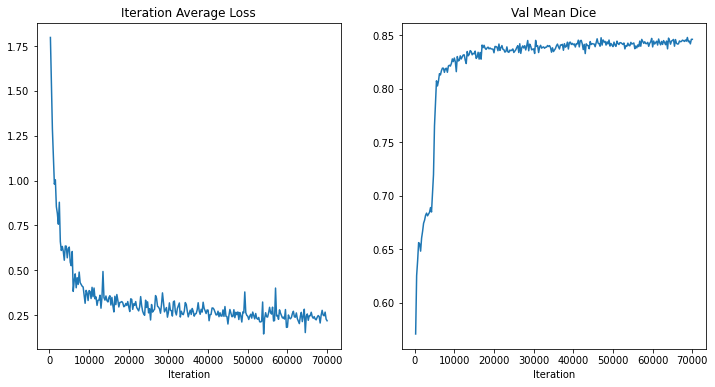

In [11]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Iteration Average Loss")
x = [eval_num * (i + 1) for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("Iteration")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val Mean Dice")
x = [eval_num * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("Iteration")
plt.plot(x, y)
plt.show()

### Check best model output with the input image and label

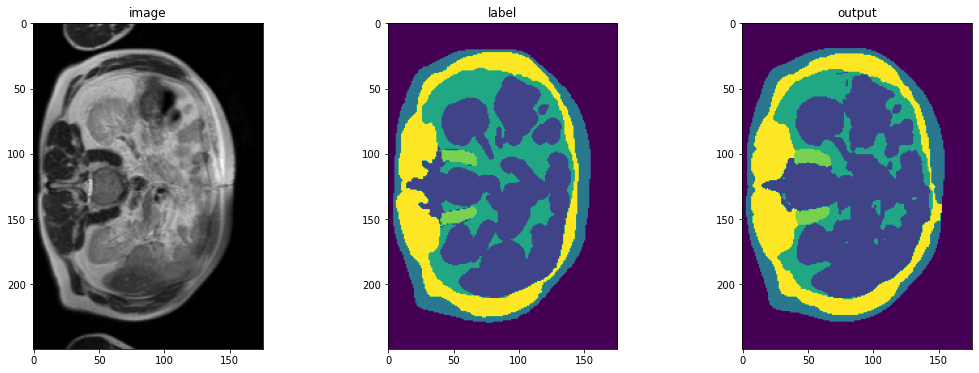

In [12]:
case_num = 0
model.load_state_dict(torch.load(os.path.join(data_dir, "TestMR10_swinUNetR_fold1.pth")))
model.eval()
with torch.no_grad():
    img_name = os.path.split(val_ds[case_num]["image_meta_dict"]["filename_or_obj"])[1]
    img = val_ds[case_num]["image"]
    label = val_ds[case_num]["label"]
    val_inputs = torch.unsqueeze(img, 1).to(device)
    val_labels = torch.unsqueeze(label, 1).to(device)
    val_outputs = sliding_window_inference(
        val_inputs, (96, 96, 96), 4, model, overlap=0.8
    )
    plt.figure("check", (18, 6))
    plt.subplot(1, 3, 1)
    plt.title("image")
    plt.imshow(val_inputs.cpu().numpy()[0, 0, :, :, 5], cmap="gray")
    plt.subplot(1, 3, 2)
    plt.title("label")
    plt.imshow(val_labels.cpu().numpy()[0, 0, :, :, 5])
    plt.subplot(1, 3, 3)
    plt.title("output")
    plt.imshow(
        torch.argmax(val_outputs, dim=1).detach().cpu()[0, :, :, 5]
    )
    plt.show()
    

### Inference on test images

In [ ]:
import glob
from monai.data import Dataset
from monai.handlers.utils import from_engine
from monai.transforms import (
    AsDiscrete,
    AsDiscreted,
    EnsureChannelFirstd,
    Compose,
    CropForegroundd,
    LoadImaged,
    Orientationd,
    RandCropByPosNegLabeld,
    SaveImaged,
    ScaleIntensityRanged,
    Spacingd,
    EnsureTyped,
    EnsureType,
    Invertd,
)

test_images = sorted(
    glob.glob(os.path.join(data_dir, "imagesTs", "*.nii.gz")))

test_data = [{"image": image} for image in test_images]


test_org_transforms = Compose(
    [
        LoadImaged(keys="image"),
        EnsureChannelFirstd(keys="image"),
        Orientationd(keys=["image"], axcodes="RAS"),
        Spacingd(keys=["image"], pixdim=(
            1.5, 1.5, 1.0), mode="bilinear"),
        ScaleIntensityRanged(
            keys=["image"], a_min=0, a_max=200,
            b_min=0.0, b_max=1.0, clip=False,
        ),
        CropForegroundd(keys=["image"], source_key="image"),
        EnsureTyped(keys="image"),
    ]
)

test_org_ds = Dataset(
    data=test_data, transform=test_org_transforms)

test_org_loader = DataLoader(test_org_ds, batch_size=1, num_workers=4)

post_transforms = Compose([
    EnsureTyped(keys="pred"),
    Invertd(
        keys="pred",
        transform=test_org_transforms,
        orig_keys="image",
        meta_keys="pred_meta_dict",
        orig_meta_keys="image_meta_dict",
        meta_key_postfix="meta_dict",
        nearest_interp=False,
        to_tensor=True,
    ),
    AsDiscreted(keys="pred", argmax=True, to_onehot=6),
    SaveImaged(keys="pred", meta_keys="pred_meta_dict", output_dir="./outMR10swinfold1", output_postfix="seg", resample=False, separate_folder=False),
])

In [ ]:
from monai.transforms import LoadImage
loader = LoadImage()

model.load_state_dict(torch.load(
    os.path.join(data_dir, "TestMR10_swinUNetR_fold1.pth")))
model.eval()

with torch.no_grad():
    for test_data in test_org_loader:
        test_inputs = test_data["image"].to(device)
        roi_size = (96, 96, 96)
        sw_batch_size = 4
        test_data["pred"] = sliding_window_inference(
            test_inputs, roi_size, sw_batch_size, model, overlap=0.8)

        test_data = [post_transforms(i) for i in decollate_batch(test_data)]

#         # uncomment the following lines to visualize the predicted results
        test_output = from_engine(["pred"])(test_data)

        original_image = loader(test_data[0]["image_meta_dict"]["filename_or_obj"])[0]

        plt.figure("check", (18, 6))
        plt.subplot(1, 4, 1)
        plt.imshow(original_image[:, :, 8], cmap="gray")
        plt.subplot(1, 4, 2)
        plt.imshow(test_output[0].detach().cpu()[2, :, :, 8])
        plt.subplot(1, 4, 3)
        plt.imshow(test_output[0].detach().cpu()[3, :, :, 8])
        plt.subplot(1, 4, 4)
        plt.imshow(test_output[0].detach().cpu()[5, :, :, 8])
        plt.show()

In [ ]:
!tar -cvzf outMR10swinfold1.tar.gz outMR10swinfold1